In [25]:
# Import des bibliothèques
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    get_scheduler,
)
from torch.optim import AdamW  # Import depuis PyTorch
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import optuna
import mlflow
import json

In [ ]:
# Configuration
config = {
    "model_name": "distilbert-base-uncased",
    "num_labels": 2,
    "max_len": 128,
    "batch_size": 32,
    "learning_rate": 5e-5,
    "num_epochs": 3,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "data_path": "data/train_df.csv",
    "mlflow_experiment_name": "distilbert_text_classification_experiment",
}

# Initialiser MLflow
mlflow.set_experiment(config["mlflow_experiment_name"])

<Experiment: artifact_location='file:///c:/Users/devil/Projets/air%20paradis/project-Air-Paradis/mlruns/247880020185134400', creation_time=1737454886750, experiment_id='247880020185134400', last_update_time=1737454886750, lifecycle_stage='active', name='distilbert_text_classification_experiment', tags={}>

In [ ]:
# Chargement des données
class BertDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(
            text, padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }


def prepare_data(X, y, tokenizer, batch_size, max_len, shuffle=True):
    dataset = BertDataset(X, y, tokenizer, max_len)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

# Initialiser le tokenizer
print("Initialisation du tokenizer...")
tokenizer = DistilBertTokenizer.from_pretrained(config["model_name"])

Initialisation du tokenizer...


In [4]:
# Charger les données et les séparer en train et test
data = pd.read_csv(config["data_path"]).dropna(subset=["text"])
X_train, X_test, y_train, y_test = train_test_split(
    data["text"], data["target"], test_size=0.2, random_state=42
)

In [5]:
# Préparer les DataLoaders avec sous-échantillonnage pour accélérer
X_train_sample = X_train.sample(frac=0.1, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]
train_loader = prepare_data(X_train_sample, y_train_sample, tokenizer, config["batch_size"], config["max_len"])
test_loader = prepare_data(X_test, y_test, tokenizer, config["batch_size"], config["max_len"], shuffle=False)

In [10]:
# Entraînement du modèle avec arrêt anticipé
def train_model(train_loader, model, optimizer, scheduler, device, num_epochs):
    previous_loss = float("inf")
    early_stop_threshold = 1e-3

    # Terminer toute exécution active
    if mlflow.active_run() is not None:
        mlflow.end_run()

    with mlflow.start_run():
        mlflow.log_param("num_epochs", num_epochs)
        mlflow.log_param("learning_rate", optimizer.param_groups[0]["lr"])
        mlflow.log_param("batch_size", train_loader.batch_size)

        model.train()
        for epoch in range(num_epochs):
            epoch_loss = 0
            for batch in tqdm(train_loader, desc=f"Époque {epoch + 1}"):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)

                optimizer.zero_grad()
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                loss.backward()
                optimizer.step()
                scheduler.step()

                epoch_loss += loss.item()

            print(f"Époque {epoch + 1}, Perte : {epoch_loss:.4f}")
            mlflow.log_metric(f"loss_epoch_{epoch + 1}", epoch_loss)

            # Vérification de l'arrêt anticipé
            if abs(previous_loss - epoch_loss) < early_stop_threshold:
                print("Arrêt anticipé : la perte ne diminue plus significativement.")
                break

            previous_loss = epoch_loss

        # Ajouter un exemple d'entrée pour la signature
        input_example = {
            "input_ids": torch.randint(0, 1000, (1, config["max_len"])),
            "attention_mask": torch.ones((1, config["max_len"])),
        }
        model.save_pretrained("./saved_models/distilbert_model")
        mlflow.pytorch.log_model(model, "distilbert_model", input_example=input_example)


In [23]:
# Evaluation
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            probs = torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy()
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()

            y_pred.extend(preds)
            y_probs.extend(probs)
            y_true.extend(labels.cpu().numpy())

    roc_auc = roc_auc_score(y_true, y_probs)
    report = classification_report(y_true, y_pred, output_dict=True)

    print("Rapport de classification :")
    print(classification_report(y_true, y_pred))
    print(f"ROC AUC Score : {roc_auc:.4f}")

    # Enregistrer la courbe ROC
    fpr, tpr, _ = roc_curve(y_true, y_probs) 
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("accuracy", report["accuracy"])
    mlflow.log_metric("precision", report["weighted avg"]["precision"])
    mlflow.log_metric("recall", report["weighted avg"]["recall"])
    mlflow.log_metric("f1_score", report["weighted avg"]["f1-score"])

    return roc_auc, report


In [8]:
# Recherche d'hyperparamètres
def objective(trial):
    # Terminer toute exécution active
    if mlflow.active_run() is not None:
        mlflow.end_run()

    with mlflow.start_run():
        learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-4, log=True)
        batch_size = trial.suggest_categorical("batch_size", [16, 32])
        num_epochs = trial.suggest_int("num_epochs", 1, 3)
        max_len = trial.suggest_categorical("max_len", [128, 256])

        train_loader = prepare_data(X_train_sample, y_train_sample, tokenizer, batch_size, max_len, shuffle=True)
        test_loader = prepare_data(X_test, y_test, tokenizer, batch_size, max_len, shuffle=False)

        model = DistilBertForSequenceClassification.from_pretrained(
            config["model_name"], num_labels=config["num_labels"]
        ).to(config["device"])

        optimizer = AdamW(model.parameters(), lr=learning_rate)
        scheduler = get_scheduler(
            "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * num_epochs
        )

        train_model(train_loader, model, optimizer, scheduler, config["device"], num_epochs)

        roc_auc, _ = evaluate_model(model, test_loader, config["device"])
        return roc_auc


In [11]:
# Lancer l'optimisation
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print("Meilleurs paramètres :", study.best_params)

[I 2025-01-23 06:30:14,193] A new study created in memory with name: no-name-2ab0fd43-8720-44b5-98be-8efeb17fe2c8
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Époque 1: 100%|██████████| 640/640 [24:41<00:00,  2.31s/it]


Époque 1, Perte : 303.7130


2025/01/23 06:55:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-01-23 06:57:00,321] Trial 0 finished with value: 0.7984769754852383 and parameters: {'learning_rate': 1.6387127653029488e-05, 'batch_size': 16, 'num_epochs': 1}. Best is trial 0 with value: 0.7984769754852383.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Époque 1: 100%|██████████| 320/320 [21:43<00:00,  4.07s/it]


Époque 1, Perte : 162.5116


2025/01/23 07:19:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-01-23 07:20:44,919] Trial 1 finished with value: 0.7886421997181258 and parameters: {'learning_rate': 1.2034766060380194e-05, 'batch_size': 32, 'num_epochs': 1}. Best is trial 0 with value: 0.7984769754852383.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Époque 1: 100%|██████████| 320/320 [22:30<00:00,  4.22s/it]


Époque 1, Perte : 161.8025


Époque 2: 100%|██████████| 320/320 [33:11<00:00,  6.22s/it]


Époque 2, Perte : 121.3418


Époque 3: 100%|██████████| 320/320 [38:04<00:00,  7.14s/it]


Époque 3, Perte : 104.4027


2025/01/23 08:55:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-01-23 08:58:24,320] Trial 2 finished with value: 0.8043119197177107 and parameters: {'learning_rate': 1.225888800628739e-05, 'batch_size': 32, 'num_epochs': 3}. Best is trial 2 with value: 0.8043119197177107.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Époque 1: 100%|██████████| 640/640 [26:46<00:00,  2.51s/it]


Époque 1, Perte : 301.7285


2025/01/23 09:25:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-01-23 09:27:25,570] Trial 3 finished with value: 0.7976352590673733 and parameters: {'learning_rate': 7.980181689646345e-05, 'batch_size': 16, 'num_epochs': 1}. Best is trial 2 with value: 0.8043119197177107.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Époque 1: 100%|██████████| 320/320 [30:30<00:00,  5.72s/it]


Époque 1, Perte : 155.5521


Époque 2: 100%|██████████| 320/320 [26:01<00:00,  4.88s/it]


Époque 2, Perte : 92.1988


Époque 3: 100%|██████████| 320/320 [25:39<00:00,  4.81s/it]


Époque 3, Perte : 35.8646


2025/01/23 10:50:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-01-23 10:52:47,633] Trial 4 finished with value: 0.8090765595711213 and parameters: {'learning_rate': 7.562390860135907e-05, 'batch_size': 32, 'num_epochs': 3}. Best is trial 4 with value: 0.8090765595711213.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Époque 1: 100%|██████████| 640/640 [32:35<00:00,  3.05s/it]


Époque 1, Perte : 308.9544


Époque 2: 100%|██████████| 640/640 [34:45<00:00,  3.26s/it] 


Époque 2, Perte : 212.9050


2025/01/23 12:00:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-01-23 12:02:43,224] Trial 5 finished with value: 0.8006725185998576 and parameters: {'learning_rate': 1.7250944779022217e-05, 'batch_size': 16, 'num_epochs': 2}. Best is trial 4 with value: 0.8090765595711213.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Époque 1: 100%|██████████| 320/320 [24:24<00:00,  4.58s/it]


Époque 1, Perte : 153.3133


Époque 2: 100%|██████████| 320/320 [24:51<00:00,  4.66s/it]


Époque 2, Perte : 86.3798


2025/01/23 12:52:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-01-23 12:54:27,609] Trial 6 finished with value: 0.8004823846882079 and parameters: {'learning_rate': 6.892415715155969e-05, 'batch_size': 32, 'num_epochs': 2}. Best is trial 4 with value: 0.8090765595711213.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Époque 1: 100%|██████████| 640/640 [26:43<00:00,  2.50s/it]


Époque 1, Perte : 311.8071


2025/01/23 13:21:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-01-23 13:23:43,941] Trial 7 finished with value: 0.7940562857416656 and parameters: {'learning_rate': 1.3142809856982769e-05, 'batch_size': 16, 'num_epochs': 1}. Best is trial 4 with value: 0.8090765595711213.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Époque 1: 100%|██████████| 640/640 [25:31<00:00,  2.39s/it]


Époque 1, Perte : 297.1381


2025/01/23 13:49:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-01-23 13:51:55,277] Trial 8 finished with value: 0.7995857339138471 and parameters: {'learning_rate': 3.5744875140743397e-05, 'batch_size': 16, 'num_epochs': 1}. Best is trial 4 with value: 0.8090765595711213.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Époque 1: 100%|██████████| 320/320 [24:46<00:00,  4.64s/it]


Époque 1, Perte : 151.1052


2025/01/23 14:17:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-01-23 14:19:07,296] Trial 9 finished with value: 0.8057756151274568 and parameters: {'learning_rate': 2.4335366756715682e-05, 'batch_size': 32, 'num_epochs': 1}. Best is trial 4 with value: 0.8090765595711213.


Meilleurs paramètres : {'learning_rate': 7.562390860135907e-05, 'batch_size': 32, 'num_epochs': 3}


In [13]:
df_best_params = pd.DataFrame([study.best_params])
# Sauvegarder en CSV
df_best_params.to_csv("best_params.csv", index=False)

In [36]:
# Entraînement final avec les meilleurs hyperparamètres
best_params = study.best_params
model = DistilBertForSequenceClassification.from_pretrained(
    config["model_name"], num_labels=config["num_labels"]
).to(config["device"])

optimizer = AdamW(model.parameters(), lr=best_params["learning_rate"])
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * best_params["num_epochs"],
)

train_model(train_loader, model, optimizer, scheduler, config["device"], 10)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Époque 1: 100%|██████████| 32/32 [03:13<00:00,  6.06s/it]


Époque 1, Perte : 20.3801


Époque 2: 100%|██████████| 32/32 [03:34<00:00,  6.69s/it]


Époque 2, Perte : 13.0615


Époque 3: 100%|██████████| 32/32 [03:38<00:00,  6.83s/it]


Époque 3, Perte : 7.1236


Époque 4: 100%|██████████| 32/32 [04:14<00:00,  7.95s/it]


Époque 4, Perte : 5.6581


Époque 5: 100%|██████████| 32/32 [03:26<00:00,  6.46s/it]


Époque 5, Perte : 5.6650


Époque 6: 100%|██████████| 32/32 [03:25<00:00,  6.42s/it]


Époque 6, Perte : 5.7706


Époque 7: 100%|██████████| 32/32 [03:29<00:00,  6.54s/it]


Époque 7, Perte : 5.8157


Époque 8: 100%|██████████| 32/32 [04:03<00:00,  7.62s/it]


Époque 8, Perte : 5.9404


Époque 9: 100%|██████████| 32/32 [04:52<00:00,  9.15s/it]


Époque 9, Perte : 5.8551


Époque 10: 100%|██████████| 32/32 [04:44<00:00,  8.90s/it]


Époque 10, Perte : 6.1282


2025/01/23 17:01:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Évaluation du modèle final :
Rapport de classification :
              precision    recall  f1-score   support

           0       0.73      0.83      0.78      1271
           1       0.81      0.70      0.75      1289

    accuracy                           0.76      2560
   macro avg       0.77      0.76      0.76      2560
weighted avg       0.77      0.76      0.76      2560

ROC AUC Score : 0.8435


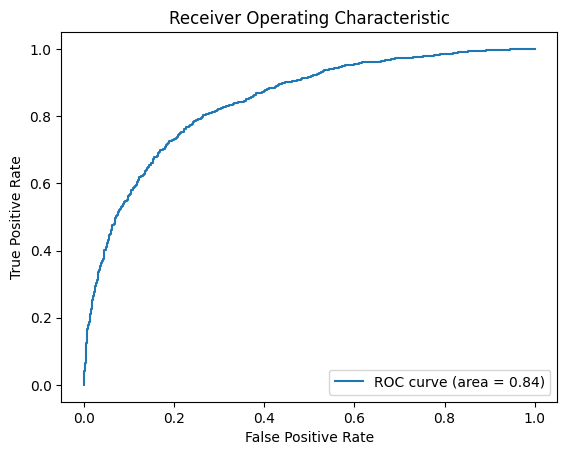

In [37]:
# Évaluer le modèle final
print("Évaluation du modèle final :")
roc_auc, report = evaluate_model(model, test_loader, config["device"])


In [38]:
# Sauvegarder le modèle final
model.save_pretrained("./saved_models/final_distilbert_model")
print("Modèle final sauvegardé dans './saved_models/final_distilbert_model'")

Modèle final sauvegardé dans './saved_models/final_distilbert_model'


In [39]:
report

{'0': {'precision': 0.7299723756906077,
  'recall': 0.8316286388670339,
  'f1-score': 0.7774917248988599,
  'support': 1271.0},
 '1': {'precision': 0.8075539568345323,
  'recall': 0.6966640806826998,
  'f1-score': 0.7480216576426489,
  'support': 1289.0},
 'accuracy': 0.763671875,
 'macro avg': {'precision': 0.76876316626257,
  'recall': 0.7641463597748668,
  'f1-score': 0.7627566912707544,
  'support': 2560.0},
 'weighted avg': {'precision': 0.7690359140087791,
  'recall': 0.763671875,
  'f1-score': 0.7626530855655569,
  'support': 2560.0}}